# CSE 152: Intro to Computer Vision - Winter 2020 Assignment 3
## Instructor: David Kriegman
### Assignment published on Wednesday, February 26, 2020
### Due on Wednesday, March 4, 2020

## Instructions
* This assignment must be completed individually. Review the academic integrity and collaboration policies on the course website.
* All solutions should be written in this notebook.
* If you want to modify the skeleton code, you may do so. It has been merely been provided as a framework for your solution.
* You may use Python packages for basic linear algebra (e.g. NumPy or SciPy for basic operations), but you may not use packages that directly solve the problem. If you are unsure about using a specific package or function, ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF. You must also submit this notebook as an `.ipynb` file. Submit both files (`.pdf` and `.ipynb`) on Gradescope. **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late policy:** a penalty of 10% per day after the due date.

---

## Problem 1. Photometric Stereo [15 pts]

Implement the photometric stereo technique described in the lecture slides and in Forsyth and Ponce 2.2.4 (*Photometric Stereo: Shape from Multiple Shaded Images*). Your program should have two parts:

1. Read in the images and corresponding light source directions, and estimate the surface normals and albedo map.

1. Reconstruct the depth map from the surface normals using the Horn integration technique given below in `horn_integrate` function. Note that you will typically want to run the `horn_integrate` function with 10000 - 100000 iterations, meaning it will take a while.


### Data
You will use the synthetic pear images as data. These images are stored in `.pickle` files which were graciously provided by Satya Mallick. The `specular_pear.pickle` file contains

* `im1`, `im2`, `im3`, `im4`, ... images.
* `l1`, `l2`, `l3`, `l4`, ... light source directions.

You are also provided a mask in the `masks.pkl` fule. You will apply this masks during your reconstruction. 



1. You will find all the data for this part in `specular_pear.pickle`. Use only `im1`, `im2` and `im4`. Use the mask provided to you during reconstruction. 

1. Then use all four images (most accurate) - you will need to use linear least-squares to accomplish this. Again use the provided mask.

1. Using the mask provided, check to see if each pixel has 4 values higher than a threshold that you set. If yes, use least squares on that pixel. If not, then calculate the b values for that pixel using the images that have the three highest intensity values at that pixel.


For each of these sub-problems, you will also reduce the impact of specularity by implementing a threshold on the upper value of pixel intensities. You can tune this threshold until you achieve a an acceptable result. 


For **each** of the **two above cases** you must output:

1. The estimated albedo map.

1. The estimated surface normals by showing both
    1. Needle map, and
    1. Three images showing components of surface normal.

1. A wireframe of depth map.

An example of outputs is shown in the figure below.

![Problem1 example](Problem1_example.png)

In [1]:
# you will want to convert your images to grayscale and normalize them before processing
def grayscale(img):
    '''
    Converts RGB image to Grayscale
    '''
    gray=np.zeros((img.shape[0],img.shape[1]))
    gray=img[:,:,0]*0.2989+img[:,:,1]*0.5870+img[:,:,2]*0.1140
    return gray

def normalize(im1):
    minimum = np.min(im1)
    maximum = np.max(im1)
    norm_image = (im1-minimum)/(maximum-minimum)
    return norm_image

### PEAR DATA 

Keys: dict_keys(['l4', 'c', '__header__', '__globals__', 'im1', 'im3', 'im2', 'l2', 'im4', 'l1', '__version__', 'l3'])
Image:


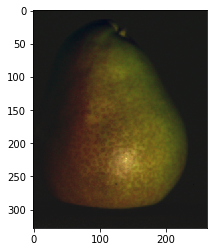

Light source direction: [[-0.342463 -0.263317  0.901877]]


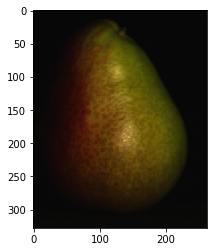

Light source direction: [[-0.350453  0.29889   0.887608]]


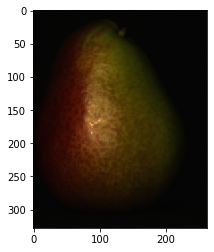

Light source direction: [[0.27204  0.337208 0.901268]]


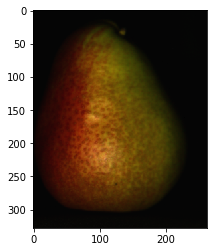

Light source direction: [[ 0.229382 -0.10682   0.967457]]


In [2]:
## Example: How to read and access data from a pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
### Example: how to read and access data from a .pickle file
pickle_in = open("specular_pear.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

# data is a dict which stores each element as a key-value pair. 
print("Keys: " + str(data.keys()))

# To access the value of an entity, refer it by its key.
print("Image:")
plt.imshow(normalize(data["im1"]))
plt.show()

print("Light source direction: " + str(data["l1"]))

plt.imshow(normalize(data["im2"]), cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l2"]))

plt.imshow(normalize(data["im3"]), cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l3"]))

plt.imshow(normalize(data["im4"]), cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l4"]))


# import mask data
pickle_in = open("masks.pkl", "rb")
masks = pickle.load(pickle_in, encoding="latin1")
pear_mask = masks[1]

### Use the images above to infer what the coordinate system for this problem will look like (left hand system)

In [3]:
import numpy as np
from scipy.signal import convolve
from numpy import linalg

def horn_integrate(gx, gy, mask, niter):
    """
    horn_integrate recovers the function g from its partial 
    derivatives gx and gy. 
    mask is a binary image which tells which pixels are 
    involved in integration. 
    niter is the number of iterations. 
    typically 100,000 or 200,000, 
    although the trend can be seen even after 1000 iterations.
    """
    g = np.ones(np.shape(gx))
    
    gx = np.multiply(gx, mask)
    gy = np.multiply(gy, mask)
    
    A = np.array([[0,1,0],[0,0,0],[0,0,0]]) #y-1
    B = np.array([[0,0,0],[1,0,0],[0,0,0]]) #x-1
    C = np.array([[0,0,0],[0,0,1],[0,0,0]]) #x+1
    D = np.array([[0,0,0],[0,0,0],[0,1,0]]) #y+1
    
    d_mask = A + B + C + D
    
    den = np.multiply(convolve(mask,d_mask,mode="same"),mask)
    den[den == 0] = 1
    rden = 1.0 / den
    mask2 = np.multiply(rden, mask)
    
    m_a = convolve(mask, A, mode="same")
    m_b = convolve(mask, B, mode="same")
    m_c = convolve(mask, C, mode="same")
    m_d = convolve(mask, D, mode="same")
    
    term_right = np.multiply(m_c, gx) + np.multiply(m_d, gy)
    t_a = -1.0 * convolve(gx, B, mode="same")
    t_b = -1.0 * convolve(gy, A, mode="same")
    term_right = term_right + t_a + t_b
    term_right = np.multiply(mask2, term_right)
    
    for k in range(niter):
        g = np.multiply(mask2, convolve(g, d_mask, mode="same")) + term_right
    
    return g

### Problem 1.A: Photo Stereo Code [5 pts]

In [4]:
def photometric_stereo(images, lights, mask, horn_niter=10000, thirdType=False):
    
    """    
    You should apply the mask during the horn integration.
    
    """

    """ ==========
    YOUR CODE HERE
    ========== """
    
#     # note:
#     # images : (n_ims, h, w)
#     # lights : (n_ims, 3)
#     # mask   : (h, w)

    upperThresh = .3

    lowerThresh = .1
    
    grayIms = []
    
    for image in images:
        image = normalize(image)
        image[image > upperThresh] = upperThresh
        grayIms.append(grayscale(image))
    
    
    
    vectIms = []
    
    for image in grayIms:
        vectIms.append(image.reshape((image.size, 1)))
    
    if len(vectIms) == 3:
        EMat = np.hstack((vectIms[0], np.hstack((vectIms[1], vectIms[2]))))
        BMat = np.matmul(EMat, linalg.inv(lights.T))
    elif thirdType == False:
        EMat = np.hstack((vectIms[0], np.hstack((vectIms[1], np.hstack((vectIms[2], vectIms[3]))))))
        BMat = np.matmul(linalg.inv(np.matmul(lights.T, lights)), np.matmul(lights.T, EMat.T)).T
    else:
        EMat = np.hstack((vectIms[0], np.hstack((vectIms[1], np.hstack((vectIms[2], vectIms[3]))))))
        BMat = []
        for point in EMat:
            aboveThresh = np.sum([point > lowerThresh])
            if aboveThresh == 4:
                BMat.append(np.matmul(linalg.inv(np.matmul(lights.T, lights)), np.matmul(lights.T, point)))
            else:
                toDrop = np.argmin(point)
                cleansedPoint = np.delete(point, toDrop)
                cleansedLights = np.delete(lights, toDrop, 0)
                BMat.append(np.matmul(cleansedPoint, linalg.inv(cleansedLights.T)))
            
    
    albedo = np.sum(np.abs(BMat)**2, axis=-1)**(1./2)
    
    normals = BMat/albedo[:,None]

    normals = normals.reshape(grayIms[0].shape[0], grayIms[0].shape[1], 3)
    
    pXY = normals[...,0] / normals[...,2]
    qXY = normals[...,1] / normals[...,2]
    
    H_horn = horn_integrate(pXY, qXY, mask, horn_niter)
    
    albedo = albedo.reshape(grayIms[0].shape)
    
#     xLayer = normals[:,0].reshape((gray1.shape[0],gray1.shape[1], 1))
#     yLayer = normals[:,1].reshape((gray1.shape[0],gray1.shape[1], 1))
#     zLayer = normals[:,2].reshape((gray1.shape[0],gray1.shape[1], 1))
#     normals = np.dstack((xLayer, np.dstack((yLayer, zLayer))))
    
    
    return albedo, normals, H_horn


### Problem 1.B: Plot Case 1 - 3 Images [ 3 pts]

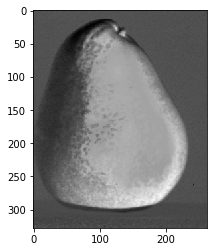

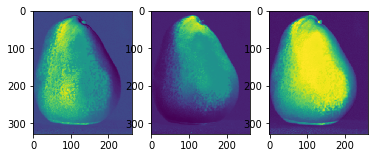

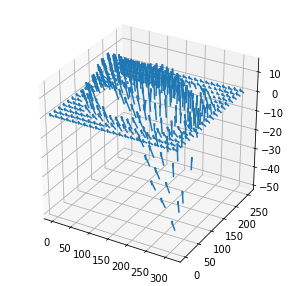

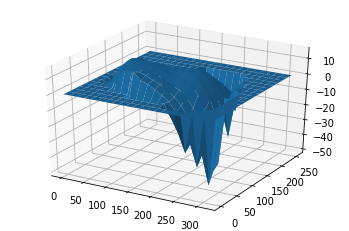

In [5]:
from mpl_toolkits.mplot3d import Axes3D

pickle_in = open("specular_pear.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l4"]))
# lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
# images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)


# mask = np.ones(data["im1"].shape)
mask = pear_mask

albedo, normals, horn = photometric_stereo(images, lights, mask)

# --------------------------------------------------------------------------
# The following code is just a working example so you don't get stuck with any
# of the graphs required. You may want to write your own code to align the
# results in a better layout. You are also free to change the function
# however you wish; just make sure you get all of the required outputs.




# also, you may want to change the index of the normals depending on how your 
# code outputs the normal array i.e normals[...,0] vs normals [0,...]

# --------------------------------------------------------------------------

def visualize(albedo, normals, horn):
    # Stride in the plot, you may want to adjust it to different images
    stride = 15

    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo = albedo / albedo_max
    plt.imshow(albedo, cmap="gray")
    plt.show()

    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()

    # showing normals as quiver
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], 15),
                          np.arange(0,np.shape(normals)[1], 15),
                          np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    Z = horn[::stride,::stride].T
    NX = normals[..., 0][::stride,::-stride].T
    NY = normals[..., 1][::-stride,::stride].T
    NZ = normals[..., 2][::stride,::stride].T
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca(projection='3d')
    plt.quiver(X,Y,Z,NX,NY,NZ, length=10)
    plt.show()

    # plotting wireframe depth map
    H = horn[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()

visualize(albedo, normals, horn)

### Problem 1.C: Plot Case 2 - Least-Squares [3 pts]

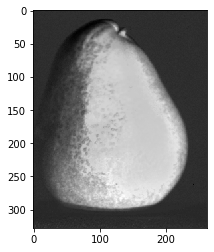

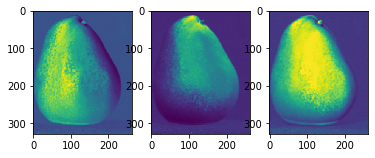

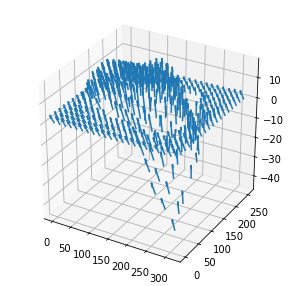

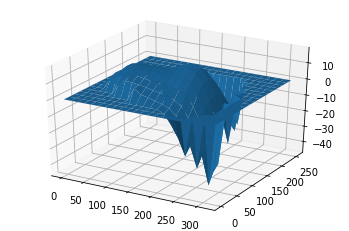

In [6]:
#### REPEAT WITH ALL 4 IMAGES ####
lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

mask = pear_mask

albedo, normals, horn = photometric_stereo(images, lights, mask)

visualize(albedo, normals, horn)

### Problem 1.D: Plot Case 3 - Standard and Least-Squares [4 pts]

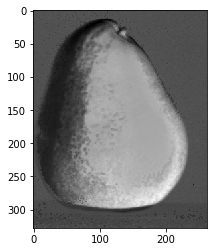

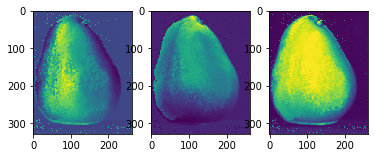

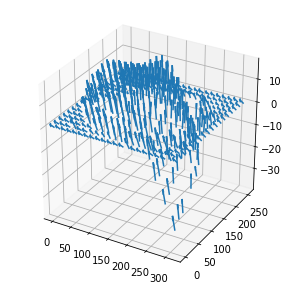

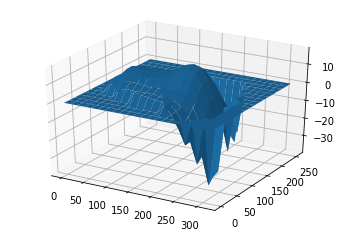

In [7]:
#### REPEAT WITH CONDITIONED RECONSTRUCTION ####
lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

mask = pear_mask

albedo, normals, horn = photometric_stereo(images, lights, mask, thirdType=True)

visualize(albedo, normals, horn)

## Problem 2. Optical Flow [15 pts]

In this problem, the single scale Lucas-Kanade method for estimating optical flow will be implemented. The data needed for this problem can be found in the folder 'beanbags' where we will use images from the Middlebury Optical Flow Dataset.

An example optical flow output is shown below - this is not a solution, just an example output.



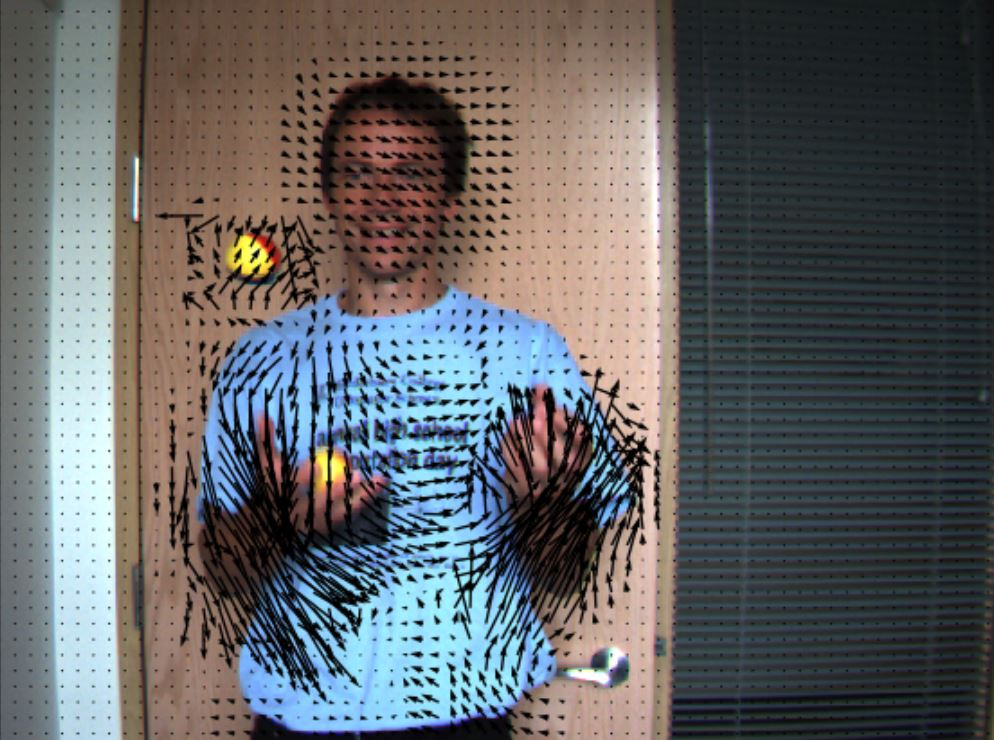

In [8]:
from IPython.display import Image
Image(filename='capture.jpg',width=600, height=400)

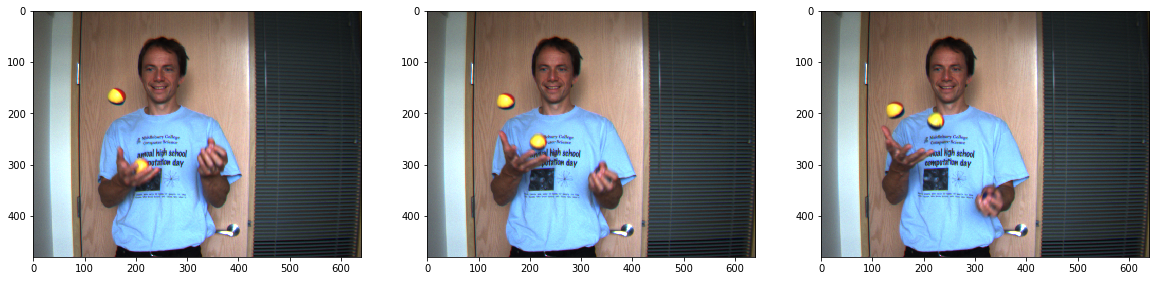

In [9]:
# import images:
import imageio as io

bean_im1 = io.imread('./beanbags/frame1.png')
bean_im2 = io.imread('./beanbags/frame2.png')
bean_im3 = io.imread('./beanbags/frame3.png')

plt.figure(figsize = (20,20))
plt.subplot(1,3,1)
plt.imshow(bean_im1)
plt.subplot(1,3,2)
plt.imshow(bean_im2)
plt.subplot(1,3,3)
plt.imshow(bean_im3)
plt.show()

In [10]:
# you will want to convert your images to grayscale and normalize them before processing
def grayscale(img):
    '''
    Converts RGB image to Grayscale
    '''
    gray=np.zeros((img.shape[0],img.shape[1]))
    gray=img[:,:,0]*0.2989+img[:,:,1]*0.5870+img[:,:,2]*0.1140
    return gray

def normalize(im1):
    minimum = np.min(im1)
    maximum = np.max(im1)
    norm_image = (im1-minimum)/(maximum-minimum)
    return norm_image

### Problem 2.A: Locus Kanade Optical Flow [6 pts]

In [11]:
def plot_optical_flow(img,U,V,titleStr, findFocus=False, pointToPlot=None):
    '''
    Plots optical flow given U,V and one of the images
    '''
    
    if findFocus:
        uvMat = np.dstack((U,V))
        magMat = np.apply_along_axis(np.linalg.norm, 2, uvMat)
        ind = np.unravel_index(np.argmin(magMat), magMat.shape)
    
    # Change t if required, affects the number of arrows
    # t should be between 1 and min(U.shape[0],U.shape[1])
    t=10 
    
    # Subsample U and V to get visually pleasing output
    U1 = U[::t,::t]
    V1 = V[::t,::t]
    
    # Create meshgrid of subsampled coordinates
    r, c = img.shape[0],img.shape[1]
    cols,rows = np.meshgrid(np.linspace(0,c-1,c), np.linspace(0,r-1,r))
    cols = cols[::t,::t]
    rows = rows[::t,::t]
    
    # Plot optical flow
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    if findFocus:
        plt.scatter(ind[1], ind[0])
    if pointToPlot != None:
        plt.scatter(pointToPlot[1], pointToPlot[0])
    plt.quiver(cols,rows,U1,-V1)
    plt.title(titleStr)
    plt.show()
    return img

In [12]:
def LucasKanade(im1, im2, window):
    """
    Inputs: the two images and window size
    Return U,V
    """
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    grayIm1 = grayscale(normalize(im1))
    grayIm2 = grayscale(normalize(im2))
    
#     temporalImg = np.dstack((grayIm1, grayIm1, grayIm2))
    partialT = grayIm1 - grayIm2 #np.squeeze(convolve(temporalImg, np.array([[[1]], [[0]], [[-1]]]).T, mode='valid'))
    
    partialX = convolve(grayIm2, np.array([[-1,0,1]]), mode='same')
    partialY = convolve(grayIm2, np.array([[-1,0,1]]).T, mode='same')
    partialX2 = np.square(partialX)
    partialY2 = np.square(partialY)
    partialXY = partialX * partialY
    partialXT = partialX * partialT
    partialYT = partialY * partialT
    
    # Creating the summation matrices
    sumX2 = convolve(partialX2, np.ones((window, window)), mode='same')
    sumXY = convolve(partialXY, np.ones((window, window)), mode='same')
    sumY2 = convolve(partialY2, np.ones((window, window)), mode='same')
    sumXT = convolve(partialXT, np.ones((window, window)), mode='same')
    sumYT = convolve(partialYT, np.ones((window, window)), mode='same')
    
    U = []
    V = []
    
    for tL,bR,tR,timeTop,timeBot in zip(np.nditer(sumX2), np.nditer(sumY2), np.nditer(sumXY), np.nditer(sumXT), np.nditer(sumYT)):
        M = np.array([[tL, tR], [tR, bR]])
        b = -np.array([[timeTop], [timeBot]])
        u = np.matmul(linalg.inv(M), b)
        U.append(u[0])
        V.append(u[1])
        
    
    U = np.reshape(np.asarray(U), grayIm1.shape)
    V = np.reshape(np.asarray(V), grayIm1.shape)
    
    return U,V

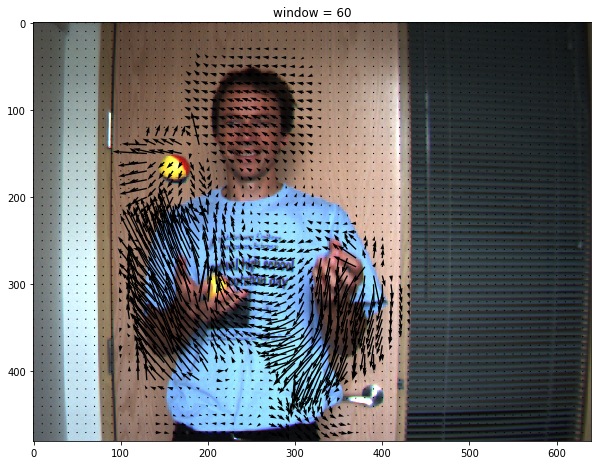

In [13]:
# Example code to generate output
window=60

U,V=LucasKanade(bean_im1,bean_im2,window)
img_out = plot_optical_flow(bean_im1,U,V, 'window = '+str(window))

### Problem 2B: Window size [3 pts]

Plot optical flow for the pair of images im1 and im2 for at least 3 different window sizes which lead to observable differences in the results. Comment on the effect of window size on your results and provide justification for your statement(s).

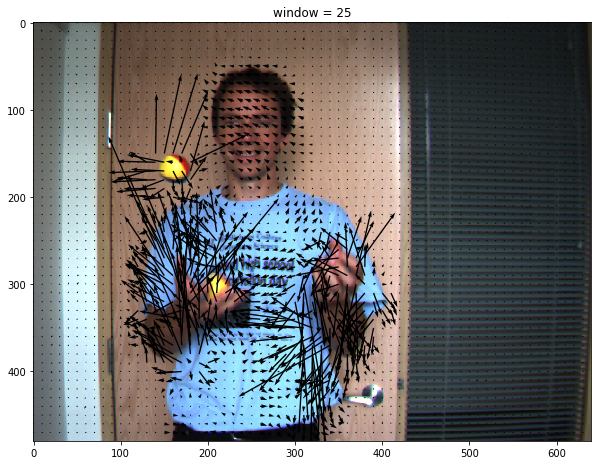

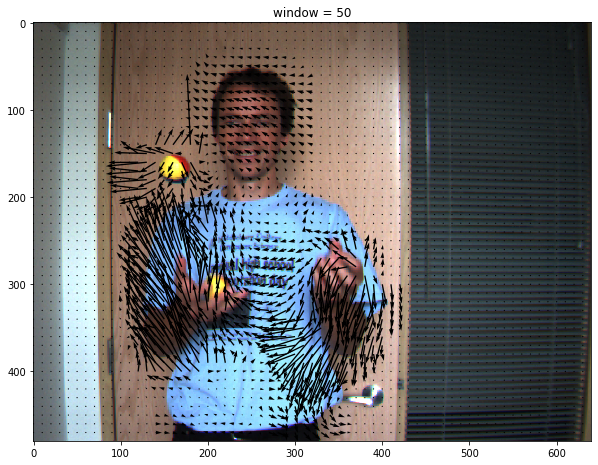

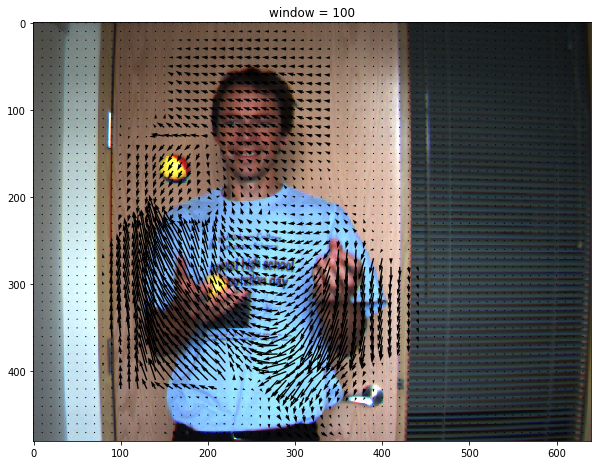

In [14]:
# Example code, change as required

""" ==========
YOUR CODE HERE
========== """
windowSizes = [25, 50, 100]
for window in windowSizes:
    U,V=LucasKanade(bean_im1, bean_im2, window)
    img_out = plot_optical_flow(bean_im1,U,V, 'window = '+str(window))

### Your answer to 2b here...

Window size seems to affect the size of the movement fields around the objects that are moving. We can see that the vectors are being drawn in a wider area in the 100 window size vs the 50 or 25. The size also seems to affect uniformity of the vectors, the larger the window the more uniform the vectors are.

### Problem 2C. All pairs [3 pts]

Find optical flow for the pairs (im1,im2), (im2,im3), (im3,im4) using a good window size. Does the optical flow result seem consistent with visual inspection? Comment on the type of motion indicated by results and visual inspection and explain why they might be consistent or inconsistent.

Ans: there is one inconsistency that I see so far in the second set of photographs. The ball is not predicted to be moving correctly, this is due to the fact that the ball was moving too fast between photos thereby breaking the assumption that objects will be near themselves in the next frame.

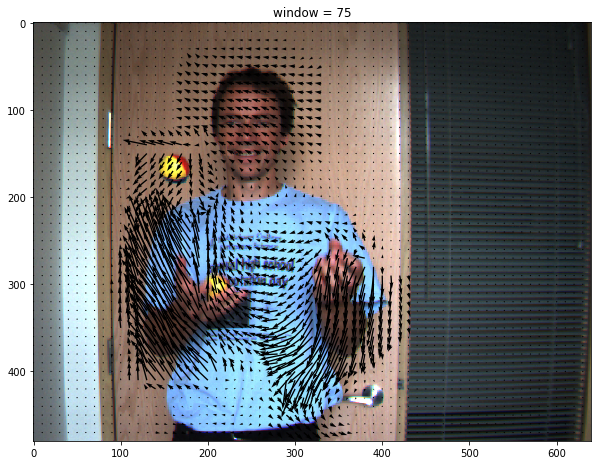

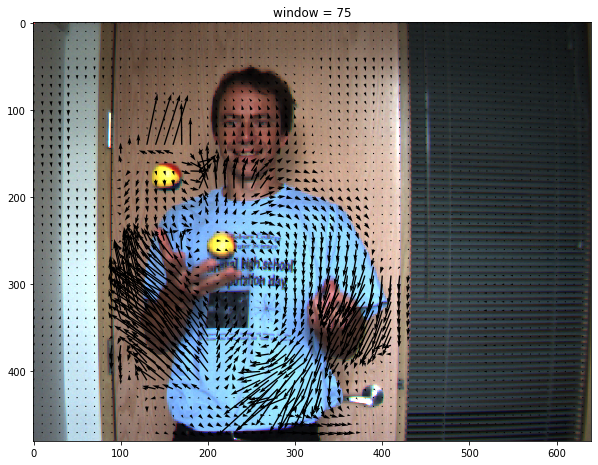

In [15]:
""" ==========
YOUR CODE HERE
========== """
window=75

U,V=LucasKanade(bean_im1, bean_im2, window)
img_out = plot_optical_flow(bean_im1,U,V, 'window = '+str(window))

U,V=LucasKanade(bean_im2, bean_im3, window)
img_out = plot_optical_flow(bean_im2,U,V, 'window = '+str(window))

### Problem 2D. Analysis [3 pts]

Give a short analysis on potential causes of failure (name at least three) in general for the Lucas-Kanade optical flow method. Also provide a possible solution to fix each of these problems.

1) fails upon large motion from objects
 - avoid objects that move too quickly\
 
2) fails on varying lighting conditions
 - ensure that lighting is similar between photographs
 
3) if the window size is too large, things that arent moving will be marked as moving
 - try smaller window sizes

##  Problem 3. RANSAC for Estimating the Focus of Expansion [10 pts]

In this problem, you will perform RANSAC to estimate the focus of expansion in the first of two images which are related by a camera translation.

### Problem 3a. Initial Focus of Expansion Estimation [5 pts]

First, compute and plot the optical flow for the pair of images `entryway1.jpg` and `entryway2.jpg`, **using a window size of 100**. Estimate the focus of expansion for the motion field as the location where the optical flow vector has the smallest magnitude, and plot this on top of the optical flow field. Comment on the result you get; does it seem accurate? If not, provide an hypothesis as to why it doesn't work.

Ans: the estimated point does look  like a decent estimation of the focus of expansion

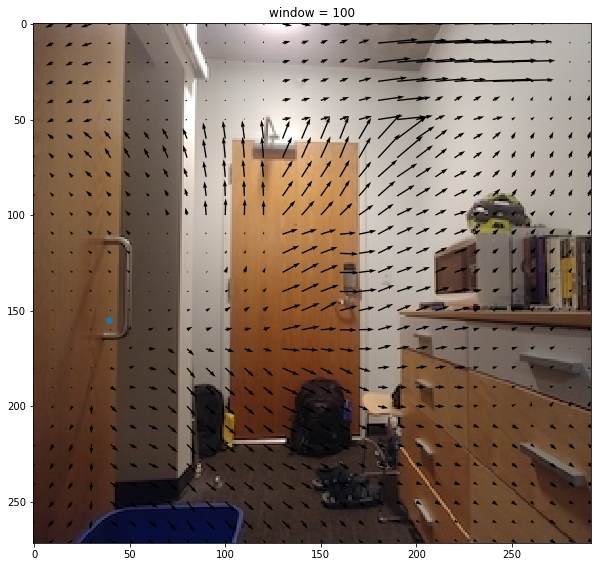

entryway1


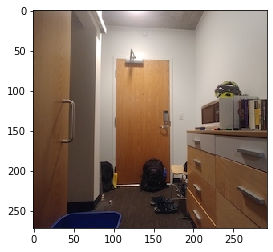

entryway2


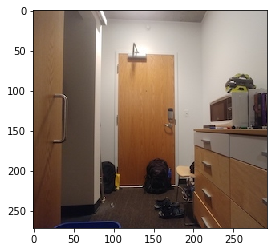

In [16]:
entryway1 = plt.imread('entryway1.jpg')
entryway2 = plt.imread('entryway2.jpg')

# ----------------------------------------------------------------------------------
# Write your code below to plot the optical flow from the `entryway1` image to the `entryway2` image,
# plotted on top of the `entryway1` image. The code should be very similar to that which you've
# written or seen a little earlier in this file.
# 
# Also estimate and plot the focus of expansion as the location corresponding
# to the flow vector with the smallest magnitude. You can use the foeX and foeY parameters
# of `plot_optical_flow` for plotting the focus of expansion.
#
# You can delete the code below; it's just so you can see what the images look like.
# ----------------------------------------------------------------------------------

window=100

U,V=LucasKanade(entryway1, entryway2, window)
img_out = plot_optical_flow(entryway1,U,V, 'window = '+str(window), True)


print('entryway1')
plt.imshow(entryway1)
plt.show()
print('entryway2')
plt.imshow(entryway2)
plt.show()

foeY, foeX = 0, 0


### Problem 3B: Estimating the Focus of Expansion with RANSAC [5 pts]

Next, use RANSAC to estimate the focus of expansion. Implement the function `foe_RANSAC` which should run optical flow on the two provided images, then in a RANSAC framework similar to that of HW2 continually (a) sample two different flow vectors, (b) estimate the focus of expansion as the intersection of the flow vectors, and (c) check the consistency of this estimate across all of the flow vectors (based on the distance of the proposed focus of expansion from each of the lines represented by the flow vectors).

There is no need to recompute everything (like you did for the fundamental matrix) at the end of all of the iterations. You are free to tune the parameters as you wish. You are also free, when checking inliers, to only use a subset of the flow vectors (e.g. the ones that are actually plotted, maybe the flow vector at every 10 grid points). This might help speed things up and should not degrade results unless you subsample massively.

In [17]:
import random

def selector(x1, x2, num):
    """
    params: x1 -> list same size as x2
            x2 -> list same size as x1
            num -> number of entries to sample
    return: list of pairs with index and corresponding values
    """
    merged_list = list(tuple(zip(x1, x2)))
    merged_list = [list(elem) for elem in merged_list]
    selected = []
    
    for i in range(num):
        selectedIdx = random.choice(range(len(merged_list)))
        selectedPair = merged_list[selectedIdx]
        selected.append((selectedIdx, selectedPair))
    
    return selected

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.85s/it]


[193.77540273 121.91012769]
Number of inliers as iteration increases:


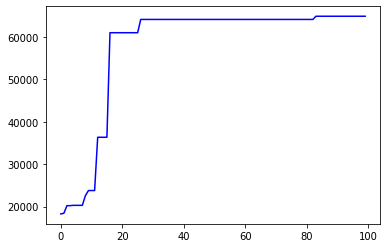

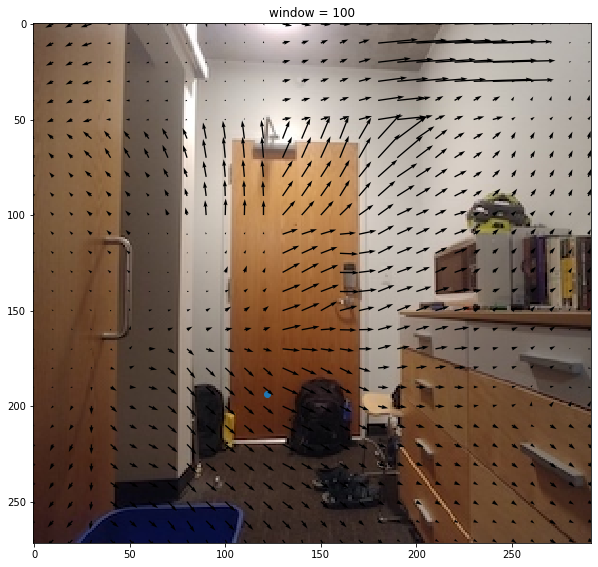

In [21]:
from tqdm import tqdm

def foe_RANSAC(im1, im2, distThreshold, nSample):
    """
    Inputs: 
      - im1, im2: two images which are related by a camera translation
      - distThreshold: distance threshold to use for inlier determination
      - nSample: number of iterations to run
    
    Return values:
      - foeX, foeY: coordinates of estimated focus of expansion
      - bestInliersIdxX, bestInliersIdxY: coordinates of inliers in max-size set
      - bestInliersNumList: list of highest number of inliers so far (at each of nSamples iterations)
    """
    
    """ ==========
    YOUR CODE HERE
    ========== """

    window = 100
    
    bestFOE = [0, 0]
    bestInliersIdxX = []
    bestInliersIdxY = []
    bestInliersNum = 0
    bestInliersNumList = []
    
    U,V=LucasKanade(im1, im2, window)
    flatU = U.flatten()
    flatV = V.flatten()

    for i in tqdm(range(nSample)):
        # do stuff
        theSuspects = selector(flatU, flatV, 2)
        xy_1 = np.unravel_index(theSuspects[0][0], U.shape)
        xy_1 = np.array([xy_1[1], xy_1[0]])
        xy_2 = np.unravel_index(theSuspects[1][0], U.shape)
        xy_2 = np.array([xy_2[1], xy_2[0]])
        v_1 = np.array(theSuspects[0][1])
        v_2 = np.array(theSuspects[1][1])
        
        originDiff = xy_2 - xy_1
        velCross = np.cross(v_1, v_2)
        rhsCross = np.cross(originDiff, v_2)
        t_1 = linalg.norm(rhsCross) / linalg.norm(velCross)
        
        suspectedFOE = xy_1 + t_1*v_1
        
        currIn = []
        
        for j in range(len(flatU)):
            testVecLoc = np.array(np.unravel_index(j, U.shape))
            testVecDir = (np.array([flatU[j], flatV[j]]))/linalg.norm(np.array([flatU[j], flatV[j]]))
            distance = linalg.norm((testVecLoc - suspectedFOE) - (np.dot((testVecLoc - suspectedFOE), testVecDir)*testVecDir))
            if distance <= distThreshold:
                currIn.append(j)
        
        if len(currIn) > bestInliersNum:
            bestInliersNum = len(currIn)
            bestFOE = suspectedFOE
            bestInliersIdxX = np.unravel_index(currIn, U.shape)[0]
            bestInliersIdxY = np.unravel_index(currIn, U.shape)[1]
        
        bestInliersNumList.append(bestInliersNum)
        

    print(bestFOE)
    return bestFOE[0], bestFOE[1], bestInliersIdxX, bestInliersIdxY, bestInliersNumList

entryway1 = plt.imread('entryway1.jpg')
entryway2 = plt.imread('entryway2.jpg')

# Estimate the focus of expansion using RANSAC
distanceThreshold = 100
nSample = 100
np.random.seed(15)
foeX, foeY, bestInliersIdxX, bestInliersIdxY, bestInliersNumList \
        = foe_RANSAC(entryway1, entryway2, distanceThreshold, nSample)

print('Number of inliers as iteration increases:')
plt.plot(np.arange(len(bestInliersNumList)), bestInliersNumList, 'b-')


# Plot the estimated focus of expansion

# ----------------------------------------------------------------------------------
# Write your code to plot the estimated focus of expansion.
# ----------------------------------------------------------------------------------
window=100

U,V=LucasKanade(entryway1,entryway2,window)
img_out = plot_optical_flow(entryway1,U,V, 'window = '+str(window), pointToPlot=[foeX, foeY])


---
## Submission Instructions
Remember to submit a PDF version of this notebook to Gradescope. Please make sure the contents in each cell are clearly shown in your final PDF file.

There are multiple options for converting the notebook to PDF:
1. You can find the export option at File $\rightarrow$ Download as $\rightarrow$ PDF via LaTeX
2. You can first export as HTML and then convert to PDF

### Please log how many hours you spent on this part of the assignment:



__________________________________________________________________________